In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score  #交叉验证评分
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error #均方根误差
from sklearn.metrics import roc_curve, auc, recall_score, precision_score
# 导入数据，路径中要么用\\或/或者在路径前加r
dataset = pd.read_csv('../data/train_chuli.csv')

In [28]:
# 输出数据预览
print(dataset.head())

   PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare  \
0            1         0       3    1  22.0      1      0   7.2500   
1            2         1       1    0  38.0      1      0  71.2833   
2            3         1       3    0  26.0      0      0   7.9250   
3            4         1       1    0  35.0      1      0  53.1000   
4            5         0       3    1  35.0      0      0   8.0500   

   family_size  Embarked_C  Embarked_Q  Embarked_S  
0            2           0           0           1  
1            2           1           0           0  
2            1           0           0           1  
3            2           0           0           1  
4            1           0           0           1  


In [29]:
from sklearn.model_selection import train_test_split #划分数据集
# 准备训练数据
x = dataset.drop(['Survived'], axis = 1)
y = dataset['Survived']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0) 
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(623, 11) (268, 11) (623,) (268,)


In [30]:
from matplotlib.cm import rainbow 
#随机森林
rf_scores = []

rf_classifier = RandomForestClassifier(n_estimators = 1000,max_depth=8, random_state = 0)
rf_classifier.fit(x_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=1000, random_state=0)

随机森林
- n_estimators=100, *, 				# 树的棵树，默认是100
- criterion='mse', 					# 默认“ mse”，衡量质量的功能，可选择“mae”。
- max_depth=None, 					# 树的最大深度。
- min_samples_split=2, 				# 拆分内部节点所需的最少样本数：
- min_samples_leaf=1, 				# 在叶节点处需要的最小样本数。
- min_weight_fraction_leaf=0.0, 		# 在所有叶节点处的权重总和中的最小加权分数。
- max_features='auto', 				# 寻找最佳分割时要考虑的特征数量。
- max_leaf_nodes=None, 				# 以最佳优先方式生长具有max_leaf_nodes的树。
- min_impurity_decrease=0.0, 			# 如果节点分裂会导致杂质的减少大于或等于该值，则该节点将被分裂。
- min_impurity_split=None, 			# 提前停止树木生长的阈值。
- bootstrap=True, 					# 建立树木时是否使用bootstrap抽样。 如果为False，则将整个数据集用于构建每棵决策树。
- oob_score=False, 					# 是否使用out-of-bag样本估算未过滤的数据的R2。
- n_jobs=None, 						# 并行运行的Job数目。
- random_state=None, 					# 控制构建树时样本的随机抽样
- verbose=0, 							# 在拟合和预测时控制详细程度。
- warm_start=False, 					# 设置为True时，重复使用上一个解决方案，否则，只需拟合一个全新的森林。
- ccp_alpha=0.0,
- max_samples=None				# 如果bootstrap为True，则从X抽取以训练每个决策树。

In [31]:
#评价指标
import numpy as np

# 计算混淆矩阵
def compute_confusion_matrix(precited,expected):
    part = precited ^ expected             # 对结果进行分类，亦或使得判断正确的为0,判断错误的为1
    pcount = np.bincount(part)             # 分类结果统计，pcount[0]为0的个数，pcount[1]为1的个数
    tp_list = list(precited & expected)    # 将TP的计算结果转换为list
    fp_list = list(precited & ~expected)   # 将FP的计算结果转换为list
    tp = tp_list.count(1)                  # 统计TP的个数
    fp = fp_list.count(1)                  # 统计FP的个数
    tn = pcount[0] - tp                    # 统计TN的个数
    fn = pcount[1] - fp                    # 统计FN的个数
    return tp, fp, tn, fn

# 计算常用指标
def compute_indexes(tp, fp, tn, fn):
    accuracy = (tp+tn) / (tp+tn+fp+fn)     # 准确率
    precision = tp / (tp+fp)               # 精确率
    recall = tp / (tp+fn)                  # 召回率
    F1 = (2*precision*recall) / (precision+recall)    # F1
    return accuracy, precision, recall, F1


In [32]:
rfc_score = rf_classifier.score(x_test, y_test)#测试集准确率,j即accuracy
expected = y_test.astype('int32')#预期值
# print(type(expected))
# print(expected)
rfc_pre=rf_classifier.predict(x_test)
precited = rfc_pre.astype('int32')#模型预测值
# print(type(precited))
tp, fp, tn, fn = compute_confusion_matrix(precited, expected)
accuracy, precision, recall, F1 = compute_indexes(tp, fp, tn, fn)
rfc_pre = rf_classifier.predict(x_test)
rfc_auc = metrics.roc_auc_score(y_test, rfc_pre)
rfc_rmse = np.sqrt(mean_squared_error(y_test, rfc_pre))
print('TP FP TN FN')
print('%d %d %d %d'%(tp,fp,tn,fn))
print('accuracy precision recall F1')
print('%.4lf %.4lf %.4lf %.4lf'%(accuracy, precision, recall, F1))
print('auc rmse')
print('%.4lf %.4lf'%(rfc_auc, rfc_rmse))

TP FP TN FN
73 19 149 27
accuracy precision recall F1
0.8284 0.7935 0.7300 0.7604
auc rmse
0.8085 0.4143


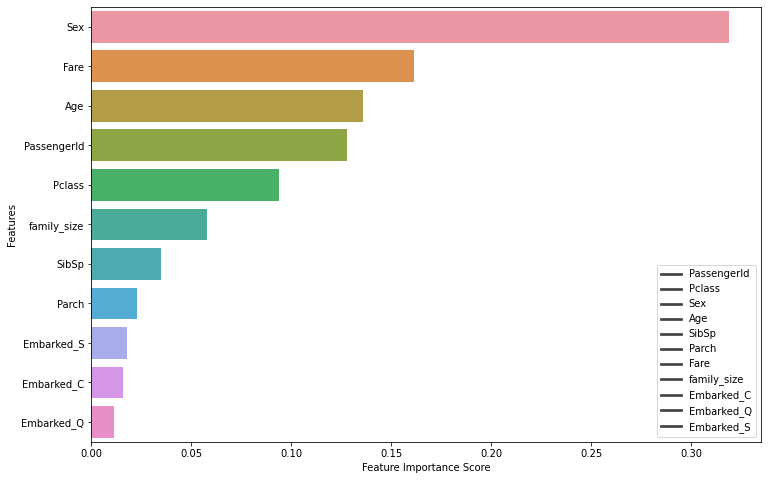

In [33]:
#特征重要性可视化
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
feature_imp = pd.Series(
    rf_classifier.feature_importances_,
    index=x_train.columns).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x=feature_imp, 
            y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.legend(x_train)
plt.show()